In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import jupyter_black

jupyter_black.load()

# Absolute hydration free energy

In [3]:
import rdkit.Chem.Draw.IPythonConsole

rdkit.Chem.Draw.IPythonConsole.ipython_3d = True

In [4]:
from functools import partial

import numpy as np

## Set up test system

In [5]:
from timemachine.datasets import fetch_freesolv
from timemachine.fe.utils import get_mol_name

In [6]:
mols = {get_mol_name(mol): mol for mol in fetch_freesolv()}

[08:12:42] Warning: molecule is tagged as 3D, but all Z coords are zero


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

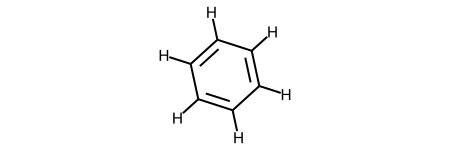

In [7]:
mol = mols["mobley_3053621"]
mol

### Parameterize solvent phase system

In [8]:
from timemachine.constants import DEFAULT_FF
from timemachine.ff import Forcefield

In [9]:
forcefield = Forcefield.load_from_file(DEFAULT_FF)

In [10]:
from timemachine.md import enhanced

In [11]:
potentials, params, masses, init_conf, box = enhanced.get_solvent_phase_system(
    mol, forcefield
)

In [12]:
potentials

## Set up alchemical transformation

We use a pre-optimized protocol for the solvent leg (see [PR](https://github.com/proteneer/timemachine/pull/538) for details)

In [13]:
from timemachine.fe.lambda_schedule import (
    construct_pre_optimized_absolute_lambda_schedule_solvent,
)

In [14]:
n_windows = 16
lambdas = construct_pre_optimized_absolute_lambda_schedule_solvent(n_windows)

# Note: by timemachine convention, lambda=1 means "decoupled", lambda=0 means "coupled"
lambdas = lambdas[::-1]
lambdas[0]

1.0

In [15]:
for U, p in zip(potentials, params):
    U.bind(p)

In [16]:
from timemachine.constants import DEFAULT_TEMP

In [17]:
temperature = DEFAULT_TEMP
temperature

300

In [18]:
from timemachine.md import moves

# maintain constant pressure and temperature
npt_mover = moves.NPTMove(
    potentials,
    None,
    masses,
    temperature,
    pressure=1.0,
    n_steps=1000,  # number of MD steps per NPT move
    seed=123,
)

In [19]:
from timemachine.md.states import CoordsVelBox

In [20]:
xvb_0 = CoordsVelBox(init_conf, np.zeros_like(init_conf), box)
type(xvb_0)

timemachine.md.states.CoordsVelBox

In [21]:
xvb_0.coords.shape

(2673, 3)

In [22]:
def propagate(xvb, lam):
    "Returns updated coordinates, velocity, and box after a single NPT move"
    npt_mover.lamb = lam
    xvb_next = npt_mover.move(xvb)
    return xvb_next

In [23]:
type(propagate(xvb_0, lambdas[0]))

timemachine.md.states.CoordsVelBox

In [24]:
def sample(xvb, lam, n_samples):
    for _ in range(n_samples):
        xvb = propagate(xvb, lam)
        yield xvb

In [25]:
from tqdm import tqdm  # for progress bar

In [26]:
n_samples = 100
burn_in_samples = 10  # number of initial samples to discard
xvb_kn = [
    list(sample(xvb_0, lam, n_samples + burn_in_samples))[burn_in_samples:]
    for lam in tqdm(lambdas)
]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [08:45<00:00, 32.82s/it]


In [27]:
conf_kn = np.array([[xvb.coords for xvb in xvb_n] for xvb_n in xvb_kn])
box_kn = np.array([[xvb.box for xvb in xvb_n] for xvb_n in xvb_kn])

In [28]:
conf_kn.shape  # (state, sample, atom, xyz)

(16, 100, 2673, 3)

In [29]:
# (coords, box) for every state and sample
xb_kn = [[(xvb.coords, xvb.box) for xvb in xvb_n] for xvb_n in xvb_kn]

## $\Delta G$ calculation

Here we sum the pair BAR $\Delta g$s for each neighboring pair of windows (could also use MBAR)

In [30]:
from timemachine.constants import BOLTZ
from timemachine.fe.functional import construct_differentiable_interface_fast

In [31]:
# construct a differentiable function returning the total energy
U_fn = construct_differentiable_interface_fast(potentials, params)

In [32]:
def reduced_potential(lam, xb):
    "Potential in units of k_B T"
    conf, box = xb
    return U_fn(conf, params, box, lam) / (BOLTZ * temperature)


def reduced_potential_n(lam, xbs):
    "Computes reduced potentials for a batch of n samples"
    return np.array([reduced_potential(lam, xb) for xb in xbs])

In [33]:
from timemachine.fe.bar import bar_with_bootstrapped_uncertainty


def pair_BAR(lam0, xb0, lam1, xb1):
    "Compute the BAR-estimated dg (in reduced units) between a pair of states"
    u0 = partial(reduced_potential_n, lam0)
    u1 = partial(reduced_potential_n, lam1)
    w_F = u1(xb0) - u0(xb0)
    w_R = u0(xb1) - u1(xb1)
    return bar_with_bootstrapped_uncertainty(w_F, w_R)

In [34]:
from timemachine.constants import KCAL_TO_KJ

pairs = list(zip(lambdas, xb_kn))  # (window, samples) pairs


kT = BOLTZ * temperature

dg_estimates = np.array(
    [
        pair_BAR(lam0, xb0, lam1, xb1)
        for (lam0, xb0), (lam1, xb1) in zip(pairs, pairs[1:])
    ]
)

dG_estimates = dg_estimates * kT / KCAL_TO_KJ
dGs, dG_errs = dG_estimates.T

In [35]:
dG, dG_err = np.array([np.sum(dGs), np.linalg.norm(dG_errs)])
dG, dG_err

(-0.20889589743093084, 0.19561336803755572)

In [36]:
mol.GetProp("dG"), mol.GetProp("dG_err")

('-0.9', '0.2')

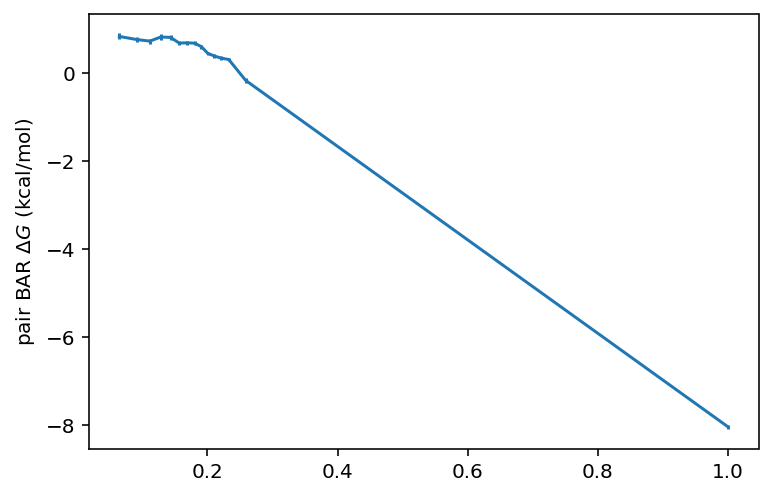

In [37]:
import matplotlib.pyplot as plt

plt.errorbar(lambdas[:-1], dGs, dG_errs)
plt.ylabel(r"pair BAR $\Delta G$ (kcal/mol)");

## Compute BAR overlaps

Useful for diagnosing issues with poor overlap between neighboring windows (especially in cases where BAR error is NaN)

In [38]:
import pymbar


def pair_overlap(lam0, xb0, lam1, xb1):
    "Compute the MBAR overlap between a pair of states"
    u0 = partial(reduced_potential_n, lam0)
    u1 = partial(reduced_potential_n, lam1)
    u_kn = [
        np.concatenate([u0(xb0), u0(xb1)]),
        np.concatenate([u1(xb0), u1(xb1)]),
    ]
    N_k = [len(xb0), len(xb1)]
    mbar = pymbar.MBAR(u_kn, N_k)
    return 2.0 * mbar.computeOverlap()["matrix"][0, 1]

In [39]:
overlaps = [
    pair_overlap(lam0, xb0, lam1, xb1)
    for (lam0, xb0), (lam1, xb1) in zip(pairs, pairs[1:])
]

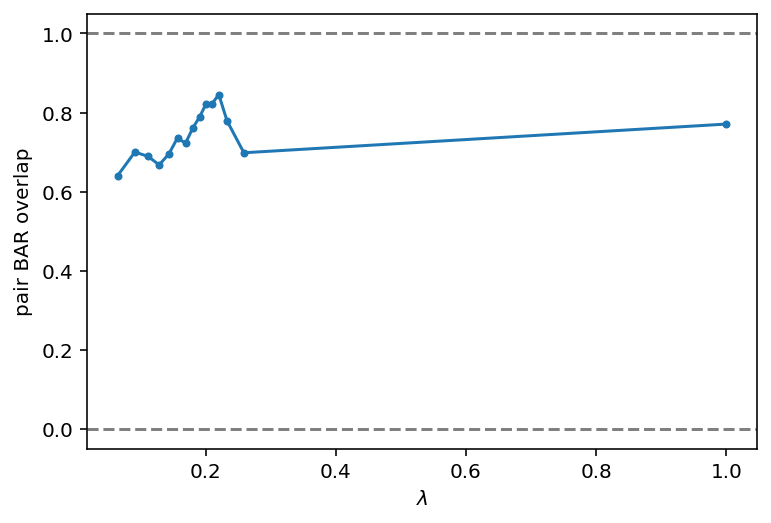

In [40]:
plt.plot(lambdas[:-1], overlaps, ".-")
plt.ylim(-0.05, 1.05)
for y in [0, 1]:
    plt.axhline(y, color="gray", ls="--")
plt.xlabel(r"$\lambda$")
plt.ylabel("pair BAR overlap");